## 1. Загрузка данных

In [1]:
# %%capture
# ! pip install kaggle

In [2]:
# from google.colab import files

In [3]:
# files.upload()

# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [4]:
# !kaggle datasets download -d mikhailklemin/kinopoisks-movies-reviews

In [5]:
# !unzip kinopoisks-movies-reviews.zip

## 2. Импорты

In [6]:
%%capture
!pip install datasets

In [7]:
import gc
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import torch
from datasets import Dataset
from nltk.probability import FreqDist
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from wordcloud import WordCloud

tqdm.pandas()

In [8]:
RANDOM_STATE = 42
N_THREADS = -1

## 3. Формирование датафрейма

In [9]:
np.random.seed(seed=RANDOM_STATE)
prop = 0.02

path = "/kaggle/input/kinodata/dataset/"
df = pd.DataFrame(columns=["review", "sentiment"])

for directory in os.listdir(path):
    if os.path.isdir(path + directory):
        files = np.array(os.listdir(path + directory))
        files_choice = np.random.choice(files, round(len(files) * prop))
        for file in tqdm(files_choice):
            with open(os.path.join(path + directory, file), encoding="utf-8") as f:
                review = f.read()
                row = pd.DataFrame({"review": [review], "sentiment": directory})
                df = pd.concat([df, row], axis=0)

df

100%|██████████| 494/494 [00:02<00:00, 192.37it/s]


,review,sentiment
0,"Ты, Моцарт, бог, и сам того не знаешь;\nЯ знаю...",pos
0,Фанатки на завтрак не остаются... Или остаются...,pos
0,Этот фильм обычным не назовешь. Так же трудно ...,pos
0,"Не надо скрывать. Это мы. Такие мы, гнилые, ка...",pos
0,"Была одна семья. Вскоре, из-за измены матери э...",pos
...,...,...
0,Детективы призваны развлекать читателя/зрителя...,neu
0,Режиссер Стивен Джилленхол в своей социальной ...,neu
0,Я всегда с нетерпением жду экранизаций любимых...,neu
0,Печально чувствовать себя взрослой и злой. \n\...,neu


In [10]:
df.reset_index(drop=True, inplace=True)

In [11]:
df.shape[0]

2634

## 4. Предварительный анализ и обработка текстов

Посмотрим на соотношение классов целевой переменной.

In [12]:
df["sentiment"].value_counts(normalize=True)

sentiment
pos    0.661731
neu    0.187547
neg    0.150721
Name: proportion, dtype: float64

Видим, что классы несбалансированы, преобладает класс с положительными оценками.

Посмотрим на несколько примеров отзывов.

In [13]:
for text in df["review"].sample(5, random_state=RANDOM_STATE):
    print(text)
    print("-----------------")

«- Когда то Одесса была спокойным и безопасным местом. Раньше, до всего этого…»  (с)

 Не успел этот год начаться, как мастер айкидо, актёр и продюсер в одном лице – могучий и несокрушимый Стивен Сигал выпустил свою новую картину. Это очередной боевик за авторством плачевно известного в узком кругу трешмейкера Киони Ваксмана – режиссёра большинства видео – релизов с некогда популярным экшен – кумиром 90 – ых. Сказать, что изначально на этот проходной, низкобюджетный боевичёк с подрастерявшим былой задор Сигалом – надежд не было не каких, думаю будет излишне. Хотя, в последнее время «Никко» взялся за себя: немного схуднул, минимизировал присутствие на экране своего молодого дублёра и начал давать дорогу подающему надежду молодняку, сам отходя временами на второй план. В этом плане удачна его вольная трилогия про некоего наёмника, выполняющего грязную работу - когда для правительства, а когда и в личных целях – начатая фильмом «Карательный Отряд», продолженная «Хорошим Человеком» и ( вер

Загрузим модель `spacy` для работы с русскими текстами.

In [ ]:
!python -m spacy download ru_core_news_sm

In [15]:
nlp = spacy.load("ru_core_news_sm")

Выполним обработку текстов.
Избавимся от стоп-слов, знаков пунктуации, пробельных символов, а также лемматизируем токены.


In [16]:
def clean_text(text):
    text = text.replace("\n", " ")
    cleaned_tokens = [
        token.lemma_.lower()
        for token in nlp(text)
        if not token.is_stop and not token.is_punct and not token.is_space
    ]
    return " ".join(cleaned_tokens)

In [17]:
%%time

df["cleaned_review"] = df["review"].progress_apply(clean_text)

100%|██████████| 2634/2634 [06:40<00:00,  6.58it/s]

CPU times: user 6min 40s, sys: 940 ms, total: 6min 41s
Wall time: 6min 40s


In [18]:
df["review_tokens"] = df["cleaned_review"].str.split()

In [19]:
df.sample(5)

,review,sentiment,cleaned_review,review_tokens
1879,"Это что-то вроде 'Верь, или умри'... Или 'Толь...",neg,верить умереть потерять близких начинать ценит...,"[верить, умереть, потерять, близких, начинать,..."
815,О сериале «Пробуждение» я узнала из топа захва...,pos,сериал пробуждение узнать топ захватывать интр...,"[сериал, пробуждение, узнать, топ, захватывать..."
116,"Каждый раз, когда расстаюсь с мужем на долгое ...",pos,раз расставаться муж долгий время неуклонно тя...,"[раз, расставаться, муж, долгий, время, неукло..."
1637,Смотрела фильм чуть ли не 5 лет назад. Но помн...,pos,смотреть фильм 5 год помнить смотреть отрывать...,"[смотреть, фильм, 5, год, помнить, смотреть, о..."
555,"Сначала 'Онг Бак', потом 'Честь дркона', тепер...",pos,онг бак честь дркона шоколад три успешный рабо...,"[онг, бак, честь, дркона, шоколад, три, успешн..."


Определим наиболее часто встречаемые слова в отзывах.

In [20]:
words = []
for w in df["review_tokens"].values:
    words += w

# Определим 100 самых часто встречаемых слов
mostcommon = FreqDist(words).most_common(100)
# Создадим объект - облако частовстречаемых слов
wordcloud = WordCloud(width=600, height=400, background_color="white").generate(
    str(mostcommon).replace("'", "")
)

100 самых часто встречаемых слов:

In [21]:
mostcommon

[('фильм', 11413),
 ('человек', 3047),
 ('герой', 2710),
 ('10', 2403),
 ('хороший', 2209),
 ('жизнь', 2200),
 ('главный', 2156),
 ('время', 1913),
 ('картина', 1866),
 ('первый', 1845),
 ('история', 1806),
 ('сюжет', 1781),
 ('год', 1667),
 ('смотреть', 1605),
 ('актёр', 1551),
 ('роль', 1526),
 ('кино', 1487),
 ('сказать', 1452),
 ('персонаж', 1410),
 ('зритель', 1392),
 ('ни', 1340),
 ('сериал', 1235),
 ('мир', 1191),
 ('раз', 1156),
 ('просмотр', 1155),
 ('игра', 1146),
 ('интересный', 1139),
 ('режиссёр', 1119),
 ('знать', 1089),
 ('сцена', 1051),
 ('посмотреть', 1041),
 ('говорить', 1012),
 ('любовь', 1012),
 ('часть', 996),
 ('момент', 980),
 ('конец', 970),
 ('новый', 945),
 ('работа', 945),
 ('дело', 936),
 ('образ', 930),
 ('стоить', 914),
 ('понравиться', 851),
 ('место', 848),
 ('видеть', 829),
 ('два', 817),
 ('друг', 812),
 ('снять', 800),
 ('сделать', 792),
 ('показать', 773),
 ('слово', 759),
 ('второй', 757),
 ('ребёнок', 755),
 ('любить', 733),
 ('играть', 727),
 ('по

Изобразим облако из ста часто втсречаемых слов.

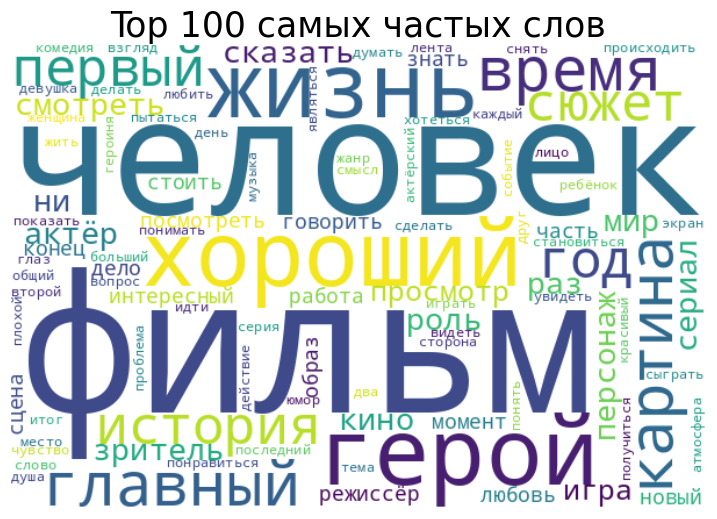

In [22]:
fig = plt.figure(figsize=(10, 5), facecolor="white")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top 100 самых частых слов", fontsize=25)
plt.tight_layout(pad=0)
plt.show()

Видим, что наиболее часто встречаемые слова являются общими ("фильм", "герой", "главный" и т.д.) - их нельзя отнести к положительным или отрицательным оценкам.  
Так же видим слово "хороший", частая встречаемость которого может быть вызвана преобладающей долей положительных отзывов.

## Создание датасета

Преобразование меток классов в числовой вид.

In [23]:
id2label = dict()
label2id = dict()
ind = 0
for i in df["sentiment"].unique():
    id2label[ind] = i
    label2id[i] = ind
    ind += 1

df["label"] = df["sentiment"].map(label2id)

Разделение на тренировочный и тестовый наборы.

In [24]:
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=RANDOM_STATE, stratify=df["sentiment"]
)

Создание объекта класса Dataset.

In [25]:
dataset = {}
dataset["text"] = list(df_train["review"])
dataset["label"] = list(df_train["label"])
ds = Dataset.from_dict(dataset)
ds = ds.train_test_split(test_size=0.1, shuffle=True, seed=RANDOM_STATE)

## Функция для расчета метрики

In [26]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, predictions, average="macro")
    return {"f1_macro": f1}

## Обучение различных моделей

В качестве моделей трансформеров в данной работе попробуем:  
- `seara/rubert-base-cased-russian-sentiment`;
- `cardiffnlp/twitter-xlm-roberta-base-sentiment`.

Загрузка моделей и токенизаторов.

In [ ]:
tokenizer_rubert_sentiment = AutoTokenizer.from_pretrained(
    "seara/rubert-base-cased-russian-sentiment"
)
model_rubert_sentiment = AutoModelForSequenceClassification.from_pretrained(
    "seara/rubert-base-cased-russian-sentiment",
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)


tokenizer_roberta_sentiment = AutoTokenizer.from_pretrained(
    "cardiffnlp/twitter-xlm-roberta-base-sentiment"
)
model_roberta_sentiment = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-xlm-roberta-base-sentiment",
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

### Определение оптимальной длины входной последовательности

In [28]:
tokenized_text_len = df_train["review"].apply(
    lambda x: len(tokenizer_rubert_sentiment.encode(x, truncation=False))
)

Text(0.5, 1.0, 'Распределение количества токенов в отзывах')

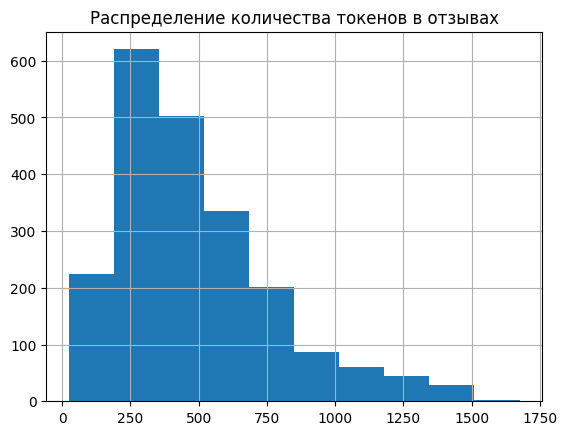

In [29]:
tokenized_text_len.hist()
plt.title("Распределение количества токенов в отзывах")

In [30]:
np.percentile(tokenized_text_len, 95)

1088.8999999999987

95% отзывов имеют длину не более 1090 токенов.  
Так как констектное окно используемых моделей составляет 512 токенов, то будем брать максимально возможную длину входной последовательности - 512 токенов.

### Обучение и тестирование RuBERT

In [31]:
data_collator_rubert = DataCollatorWithPadding(tokenizer=tokenizer_rubert_sentiment)

In [32]:
torch.cuda.empty_cache()

Функция для обучения

In [33]:
def train_model(model, tokenizer, dataset, output_dir, max_length):
    tokenized_dataset = dataset.map(
        lambda examples: tokenizer(
            examples["text"], truncation=True, max_length=max_length
        ),
        batched=True,
    )
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=1e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=10,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to=[],
        fp16=True,
        logging_strategy="epoch",
        save_total_limit=1,
        seed=RANDOM_STATE,
        data_seed=RANDOM_STATE,
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    trainer.train()

Обучение модели `seara/rubert-base-cased-russian-sentiment`.

In [34]:
train_model(
    model=model_rubert_sentiment,
    tokenizer=tokenizer_rubert_sentiment,
    dataset=ds,
    output_dir="trained_model_rubert",
    max_length=512,
)

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/211 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.808000,0.667852,0.374849
2,0.571800,0.539694,0.621014
3,0.424600,0.508644,0.749083
4,0.331800,0.651539,0.679117
5,0.234000,0.682368,0.670617
6,0.180700,0.714621,0.691833
7,0.111300,0.855581,0.645626
8,0.102400,0.830169,0.694892
9,0.056500,0.863673,0.710607
10,0.038900,0.900347,0.704423


Предсказания на тестовом наборе

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"


def predict_reviews(model, tokenizer, reviews, device):
    model.to(device)
    preds = []
    for review in reviews:
        with torch.no_grad():
            inputs = tokenizer(
                review, return_tensors="pt", truncation=True, max_length=512
            ).to(device)
            logits = model(**inputs).logits
            preds.append(logits.argmax().item())
    return preds

In [36]:
preds_rubert = predict_reviews(
    model_rubert_sentiment, tokenizer_rubert_sentiment, df_test["review"].values, device
)

In [37]:
y_true = [id2label[i] for i in df_test["label"].values]
y_pred_rubert = [id2label[i] for i in preds_rubert]

In [38]:
classification_reports = {}

classification_reports["RuBERT"] = classification_report(y_true, y_pred_rubert)

### Обучение и тестирование RoBERTa

In [39]:
data_collator_roberta = DataCollatorWithPadding(tokenizer=tokenizer_roberta_sentiment)

In [40]:
torch.cuda.empty_cache()

In [41]:
train_model(
    model=model_roberta_sentiment,
    tokenizer=tokenizer_roberta_sentiment,
    dataset=ds,
    output_dir="trained_model_roberta",
    max_length=512,
)

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/211 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.882500,0.868956,0.281462
2,0.827400,0.789959,0.402015
3,0.769700,0.751959,0.448118
4,0.722700,0.724574,0.470024
5,0.682000,0.725330,0.479688
6,0.649500,0.826882,0.437209
7,0.614100,0.742737,0.508551
8,0.582700,0.792016,0.543908
9,0.544300,0.827696,0.511486
10,0.509500,0.794291,0.557934


In [42]:
preds_roberta = predict_reviews(
    model_roberta_sentiment,
    tokenizer_roberta_sentiment,
    df_test["review"].values,
    device,
)

In [43]:
y_pred_roberta = [id2label[i] for i in preds_roberta]

In [44]:
classification_reports["RoBERTa"] = classification_report(y_true, y_pred_roberta)

### Обучение логистической регресии на эмбеддингах

Для получения эмбеддингов будем использовать модель `DeepPavlov/rubert-base-cased-sentence`

In [45]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

Получение эмбеддингов текстов.

In [47]:
batch_size = 8
max_length = 512


class TextDataset:
    def __init__(self, texts, tokenizer, max_length):
        self.encoded_texts = tokenizer(
            texts.tolist(),
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )

    def __len__(self):
        return len(self.encoded_texts["input_ids"])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encoded_texts.items()}


# Функция для среднего агрегирования
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(
        -1
    ).float()
    sum_embeddings = torch.sum(
        token_embeddings * input_mask_expanded, dim=1
    )
    sum_mask = torch.sum(input_mask_expanded, dim=1)
    return sum_embeddings / sum_mask


# Создание датасетов
train_dataset = TextDataset(
    texts=df_train["review"], tokenizer=tokenizer, max_length=max_length
)

test_dataset = TextDataset(
    texts=df_test["review"], tokenizer=tokenizer, max_length=max_length
)

# Создание DataLoader для тренировочного и тестового наборов
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, num_workers=4, pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True
)


# Функция для получения эмбеддингов
def get_embeddings(dataloader):
    embeddings = []
    for batch in dataloader:
        with torch.no_grad():
            batch = {key: val.to(device) for key, val in batch.items()}
            model_output = model(**batch)  # Прогоняем модель
            sentence_embeddings = mean_pooling(
                model_output.last_hidden_state, batch["attention_mask"]
            )
            embeddings.append(sentence_embeddings.cpu())

        del batch, model_output
        torch.cuda.empty_cache()
        gc.collect()
    return torch.cat(embeddings, dim=0)


# Получение эмбеддингов для тренировочного и тестового наборов
train_embeddings = get_embeddings(train_dataloader)
test_embeddings = get_embeddings(test_dataloader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [48]:
df_embeddings_train = pd.DataFrame(train_embeddings).astype("float")

In [49]:
df_embeddings_test = pd.DataFrame(test_embeddings).astype("float")

Обучение и тестирование модели логистической регрессии.

In [51]:
clf = LogisticRegression(random_state=RANDOM_STATE)
clf.fit(df_embeddings_train, df_train["sentiment"])
y_pred_logreg = clf.predict(df_embeddings_test)
classification_reports["Logistic Regression"] = classification_report(
    df_test["sentiment"], y_pred_logreg
)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Анализ результатов на тестовом наборе данных

In [55]:
for model_, report in classification_reports.items():
    print(f"Classification report for {model_}:")
    print(report)
    print()

Classification report for RuBERT:
              precision    recall  f1-score   support

         neg       0.75      0.59      0.66        79
         neu       0.48      0.43      0.46        99
         pos       0.86      0.92      0.89       349

    accuracy                           0.78       527
   macro avg       0.70      0.65      0.67       527
weighted avg       0.77      0.78      0.77       527


Classification report for RoBERTa:
              precision    recall  f1-score   support

         neg       0.46      0.39      0.42        79
         neu       0.10      0.01      0.02        99
         pos       0.72      0.93      0.82       349

    accuracy                           0.68       527
   macro avg       0.43      0.45      0.42       527
weighted avg       0.57      0.68      0.61       527


Classification report for Logistic Regression:
              precision    recall  f1-score   support

         neg       0.12      0.03      0.04        79
         ne

Лучшее качество предсказаний продемонстрировал RuBERT (f1_macro = 0.67).  
Хуже всего справилась модель логистической регрессии (f1_macro = 0.30).  
  
Сложнее всего моделям удаётся верно классифицировать нейтральные отзывы.  
RuBERT смог выделить 43% таких отзывов, а RoBERTa и логистическая регрессия - 1% и 6%, соответственно.

Вероятно, низкое качество моделей может быть связано с тем, что отзывы довольно большие, а мы были вынуждены ограничиться длинной контекстного окна.

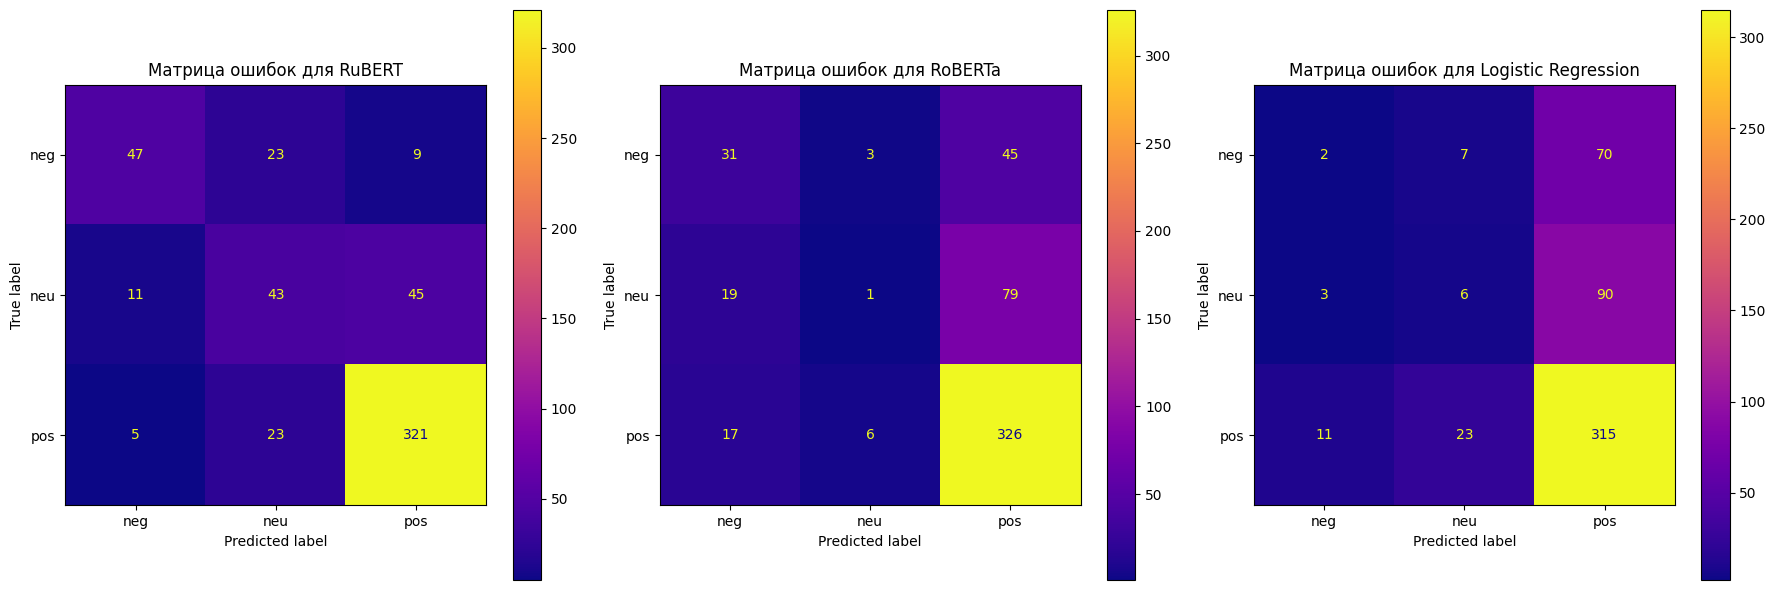

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

ConfusionMatrixDisplay.from_predictions(y_true, y_pred_rubert, cmap="plasma", ax=axs[0])
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred_roberta, cmap="plasma", ax=axs[1]
)

ConfusionMatrixDisplay.from_predictions(y_true, y_pred_logreg, cmap="plasma", ax=axs[2])


axs[0].set_title("Матрица ошибок для RuBERT")
axs[1].set_title("Матрица ошибок для RoBERTa")
axs[2].set_title("Матрица ошибок для Logistic Regression")
plt.tight_layout()

Модель логистической регрессии оказалась почти нечувствительной к нейтральным и негативным отзывам.

Посмотрим на ошибочные предсказания RuBERT

In [74]:
X_test_original = df_test["review"]
X_test_original
test_results = pd.DataFrame(
    data={
        "Оригинальный отзыв": X_test_original,
        "Истинная тональность": y_true,
        "Предсказанная тональность": y_pred_logreg,
    }
)
mistakes_rubert = test_results.loc[
    test_results["Истинная тональность"] != test_results["Предсказанная тональность"]
].sample(5, random_state=RANDOM_STATE)

In [75]:
def show_results(raw):
    print("---")
    print(f'Предсказали: {raw["Предсказанная тональность"]}')
    print("---")
    print(f'На самом деле: {raw["Истинная тональность"]}')
    print("---")
    print("Оригинальный отзыв")
    print(raw["Оригинальный отзыв"])
    print("---")
    print("\n" * 3)

In [76]:
mistakes_rubert.apply(show_results, axis=1);

---
Предсказали: neu
---
На самом деле: pos
---
Оригинальный отзыв
Именно с таким убеждением жила героиня Голди Хоун. У нее было все, о чем мечтают многие женщины: роскошные наряды, дорогие украшения, яхта, супруг под боком. Казалось бы - живи себе припеваючи! Но при этом Джоанна обладала совершенно жутким характером и абсолютно не ценила всё, что ее окружает. А, как известно, за каждую ошибку рано или поздно приходиться платить... И вот героиня оказывается «за бортом» во всех смыслах этого слова! Что из этого получится – увидите после просмотра этого великолепного фильма!

Моя жизнь похожа на смерть, дети – исчадия ада, а ты – сам дьявол! (с)

Гэрри Маршалл создал просто потрясающее кино! Идея, положенная в основу сюжета, необычная и интересная. Ведь следить за жизнью героини Голди Хоун в доме Дина – сплошное удовольствие! Персонаж Курта Рассела сразу вызывает симпатию – добродушный, красивый и трудолюбивый плотник, очень честный и порядочный. Но, как оказалось, и у него найдутся свои

Модель не смогла верно отличить явно положительный отзыв.  
Зато нагативные и нейтральные отзывы она восприняла как положительные.

Протестируем модель на других отзывах, найденных на кинопоиске.

In [77]:
new_reviews = pd.read_excel("/kaggle/input/newdata/.xlsx")

In [78]:
new_reviews["Оценка"] = new_reviews["Оценка"].map(
    {"Негативная": "neg", "Положительная": "pos", "Нейтральная": "neu"}
)

In [79]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [80]:
preds_rubert = predict_reviews(
    model_rubert_sentiment,
    tokenizer_rubert_sentiment,
    new_reviews["Отзыв"].values,
    device,
)

y_pred_rubert = [id2label[i] for i in preds_rubert]
y_pred_rubert

['neg', 'neu', 'pos', 'neg', 'neg']

In [81]:
new_reviews_results = pd.DataFrame(
    data={
        "Оригинальный отзыв": new_reviews["Отзыв"],
        "Истинная тональность": new_reviews["Оценка"],
        "Предсказанная тональность": y_pred_rubert,
    }
)
new_reviews_results

,Оригинальный отзыв,Истинная тональность,Предсказанная тональность
0,Гай Ричи достиг пика своей карьеры благодаря с...,neg,neg
1,"\nЭх, давно не попадалось такого яркого, по-хо...",pos,neu
2,\n'Еретик' режиссеров Скотта Бека и Брайана Ву...,neu,pos
3,\nШайка профессиональных мобстеров совершает д...,neu,neg
4,\nВот мы и дождались сиквела одного из спин-оф...,neg,neg


In [82]:
new_reviews_results.apply(show_results, axis=1);

---
Предсказали: neg
---
На самом деле: neg
---
Оригинальный отзыв
Гай Ричи достиг пика своей карьеры благодаря своевременным хитам 'Гнев человеческий' и 'Джельтельмены', и теперь решил снимать в своё удовольствие по принципу - купят всё.

Эту идею справедливо поддержали прокатчики, и мы увидели сразу два неинтересных фильма, которые минимально скажутся на карьере режиссера.

'Переводчик', один из них. Зачем смотреть этот фильм?

Абсолютно не зачем, если только вам не интересно послушать оригинальную афганскую речь. Тем более весь сюжет известен из описания.

Судите сами: семейный чувак, имеющий шикарный дом в Калифорнии, зачем-то воюет в Афганистане. Его спасает Ахмед, и вернувшись в США, чувак пытается совершенно наивным способом выбить тому визу по телефону. А затем, бросает эту глупость, и налегке возвращается помочь самолично.

В этом фильме, телефон и звонки - вообще двигатель сюжета.

Гай Ричи же прославился в 00-е, работал в сюрреалистично-бандитском жанре, где позволялось множ

Модель неплохо справилась с негативными отзывами, а вот верно классифицировать положительные и нейтральные ей не удалось.